# King County Millenial homeowner program

**Buying a property in King County recommendations for Millennials**

**Authors:** Hanis Zulmuthi, Greg Burgess, Kyle Weesner

***March 2022***


<img src="https://www.condosky.com/wp-content/uploads/2019/06/Young-Families-Condos-Toronto-e1561577724820.jpg" alt="A picture of a multiracial family sitting on the floor together surrounded by moving boxes" title="" />

# Overview

King County in Washington State is growing in population made up of Millenials and Generation Z who either grew up or migrated to the area and found life in the region. We, the Data Analysts at the Greek Honey Real Estate are working on building a model that predicts house prices in King County with the goal to help folks from the demographic to find their dream house that fits their lifestyle and their budget! 

## Business Problem

Housing market in King County region, especially in the major cities such as Seattle, are becoming more and more financially inaccessible for many demographics. The demographic of interest for our real-estate is millenials who are building their career, family and trying to break into the housing market to have a stable housing for themselves. With our house price predicition model, we will help them to find the market value of their ideal house that are in proximity to city centers.

## Data Understanding

### 1. King County Housing data ([kc_house_data.csv](https://github.com/hanis-z/Phase-2-project/blob/main/data/kc_house_data.csv))
**Source:** This data was provided to us by Flatiron School. This data file is available in the project repo in the folder "data". 

**Contents:**
This [file](data/column_names.md) which provides information regarding the column names and descriptions for King County data set in the years of 2014-2015.

### 2. Incorporated & Unincorporated cities in King county
**Source:** We downloaded this data from [King County GIS website]( https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::cities-and-unincorporated-king-county-city-kc-area/explore?location=47.430582%2C-121.809200%2C10.02). The data is also easily accessible in our project repo in the folder "data".

**Contents:** This dateset provided us with city boundaries of cities in King County in a shapefile along with `CITYNAME`.


### 3. Neighborhood Map of Seattle
**Source:** We attained this data from [Seattle city GIS website](https://data-seattlecitygis.opendata.arcgis.com/datasets/neighborhood-map-atlas-districts/explore?location=47.628714%2C-122.338313%2C11.43]). This data is also easily accessible in our project repo in the folder "data".

**Contents:** This dataset provided us with neighborhood boundaries of neighborhoods in Seattle city along with neighborhood (`L_HOOD`).


### Importing python libraries required for the analysis.

**Note:** To ensure that all packages are loaded successfully, please ensure that you have set up the right python environment using the [YML file](geo_env.yml) provided in this project repository.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor

from statsmodels.formula.api import ols
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

### Define Helper Functions for Data Exploration and Cleaning

In [2]:
def dataframe_info(df):
    '''
    Takes Pandas dataframe (df). Prints number of rows, number of columns, and three sample rows.
    Returns list of numerical columns and list of non-numerical columns.
    '''
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    object_cols  = df.select_dtypes(exclude=np.number).columns.tolist()

    nrows, ncol = df.shape
    nmid = nrows // 2
    
    print(f"Dimensions: {nrows} rows and {ncol} columns")
    print(f"Numeric columns: {len(numeric_cols)}")
    print(f"Object columns: {len(object_cols)}")

    display(df.iloc[[0,nmid,nrows-1]]) # show three rows: first, mid, and last

    return numeric_cols, object_cols

In [3]:
def cleaned_column_names(column_list):
    '''
    Takes list of column names (e.g. from df.columns). 
    Returns list of cleaned column names that can be assigned to DataFrame.
    Usage: df.columns = cleaned_column_names(df.columns)
    '''
    return [name.strip().lower().replace(' ','').replace('-', '_') for name in column_list]

## Data Exploration & Preparation for Linear Regression Modelling


### Load King County Housing data

In [4]:
housing_df = pd.read_csv('data/housing_gdf_complete.csv')
housing_df.columns = cleaned_column_names(housing_df.columns)

In [5]:
num, obj = dataframe_info(housing_df)

Dimensions: 21596 rows and 28 columns
Numeric columns: 17
Object columns: 11


,unnamed:0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,lat,long,sqft_living15,sqft_lot15,coord,geometry,city,dist_seattle,neighborhood,in_seattle
0,0,8856004730,9/17/2014,199950.0,2,2.75,1590,20917,1.5,NO,...,47.2786,-122.250,1310,6000,"(-122.25, 47.2786)",POINT (392815.9311460542 31962.040946318088),Algona,38586.298196,NaN,False
10798,10798,7237500590,11/17/2014,1320000.0,4,5.25,6110,10369,2.0,NO,...,47.5285,-122.135,4190,10762,"(-122.135, 47.5285)",POINT (401985.90108066204 59588.48465827319),Newcastle,19145.331588,NaN,False
21595,21595,9808100150,4/2/2015,3350000.0,5,3.75,5350,15360,1.0,NO,...,47.6480,-122.218,3740,15940,"(-122.218, 47.648)",POINT (395975.83394082234 72981.52286293103),Yarrow Point,10564.303190,NaN,False


In [6]:
print("List of numeric columns: ", num)
print("List of object columns: ", obj)

List of numeric columns:  ['unnamed:0', 'id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'dist_seattle']
List of object columns:  ['date', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'coord', 'geometry', 'city', 'neighborhood', 'in_seattle']


The original distance estimates from geopandas is in meters.

To make it more relevant, let's convert the distances to miles.

In [7]:
# convert dist_seattle from meters to miles
housing_df['dist_seattle'] = housing_df['dist_seattle'] / 1609.34

## Data Cleaning

### Basement

Creating a feature if the house has a basement or not.

In [8]:
# sqft_basement should equal difference between sqft_living and sqft_above
sqft_basement_computed = housing_df['sqft_living'] - housing_df['sqft_above']

housing_df['has_basement'] = (sqft_basement_computed > 0).astype(int)

### Year renovated

Creating a feature of houses that have been renovated in the past 5 years.

In [9]:
housing_df['sold_dt'] = pd.to_datetime(housing_df['date']) #made a new column with date by using the pd.to_datetime()
housing_df['sold_year'] = pd.DatetimeIndex(housing_df['sold_dt']).year #made a new column year sold 
housing_df['sold_month'] = pd.DatetimeIndex(housing_df['sold_dt']).month #made a new column month sold 

In [10]:
housing_df['yr_renovated_missing'] = (housing_df['yr_renovated'].isna()).astype(int) #saving nulls for accessibility
housing_df['yr_renovated'].fillna(0, inplace=True) # Rewriting dataframe filling null values with zeros

housing_df['renovated'] = ((housing_df['sold_year'] - housing_df['yr_renovated']) <= 5).astype(int) 
#houses renovated within the past 5 years

### Age of the house

Creating a feature of the age in years of the houses.

In [11]:
housing_df['house_age'] = housing_df['sold_year'] - housing_df['yr_built'] #year sold minus year built gets the age of the house
housing_df['house_age'].describe()

count    21596.000000
mean        43.323810
std         29.377864
min         -1.000000
25%         18.000000
50%         40.000000
75%         63.000000
max        115.000000
Name: house_age, dtype: float64

### View

Cleaning up missing values in the view column before using it as a feature.

In [12]:
housing_df['view_missing'] = (housing_df['view'].isna()).astype(int) #saving nulls for accessibility
housing_df['view'].fillna('NONE', inplace=True) #Rewriting dataframe filling null values with NONE

### Waterfront

Cleaning up missing values in the waterfront column before using it as a feature.

In [13]:
housing_df['waterfront_missing'] = (housing_df['waterfront'].isna()).astype(int)#saving nulls for accessibility
housing_df['waterfront'].fillna('NO', inplace=True) #Rewriting dataframe filling null values with NO

### Duplicate records (house resold)

Creating a feature of individual houses that were sold more than once (stated as a boolean value).

In [14]:
print(f"Number of rows:\t\t{len(housing_df['id'])}") #Total number of houses sold on id including repeats
print(f"Number unique:\t\t{len(housing_df['id'].unique())}") #First time houses being sold in this data set
print(f"Number duplicates:\t{sum(housing_df['id'].duplicated() == True)}") #houses being resold

Number of rows:		21596
Number unique:		21419
Number duplicates:	177


In [15]:
#sorting df by their dates so that resold rows come later in the dataframe
housing_df = housing_df.sort_values(by=['sold_year', 'sold_month']) 

#creates a boolean column for duplicated id of houses, then changes to int [0, 1]
housing_df['resold'] = housing_df.id.duplicated().astype(int) 

### Fill NaNs in neighborhood column

Replace NaNs with 'NA' string, to create category where Seattle neighborhood is "not applicable"

In [16]:
housing_df['neighborhood'] = housing_df['neighborhood'].fillna('NA')

### Ratio between bedrooms and bathrooms

Creating a feature of the ratio between bedrooms and bathrooms.

In [17]:
housing_df['br_bth'] = housing_df.bedrooms / housing_df.bathrooms

### Category `in_seattle`

Creating a feature of the with 1 correlating to yes and 0 as no if they are in the city of Seattle or not.

In [18]:
housing_df['in_seattle'] = housing_df['in_seattle'].astype(int)

## Verify that columns are not collinear

### Manually remove collinear numeric columns

As we tested collinearity of individual features with other features, we manually edited columns in `relevant_num_cols` to eliminate columns correlated > 0.7 with other columns

In [19]:
relevant_num_cols = [
    'bedrooms',
    'sqft_living',
    'sqft_lot',
    'floors',
    'dist_seattle',
    'has_basement',
    'yr_renovated_missing',
    'house_age',
    'view_missing',
    'waterfront_missing',
    'resold',
    'br_bth', 
    'renovated'
] #list of relevant numerical columns

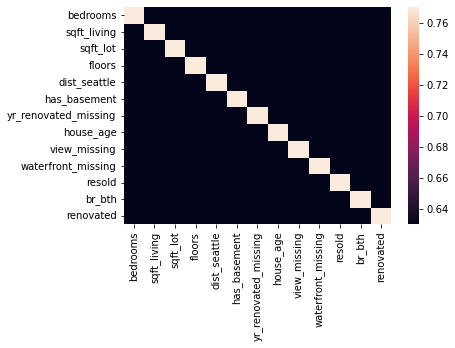

In [20]:
sns.heatmap(housing_df[relevant_num_cols].corr().abs(), vmin=.7, vmax=0.7);  
#checking for multicollinerarity between features using .7 as the cut off value

### Remove collinear categorical columns

Collinearity of categorical columns will need to be verified using VIF after running statsmodels. Here, we are creating a list of categorical columns that we want to keep for our model. As we find that the columns were collinear (using VIF), we removed the column from this list.

In [21]:
relevant_cat_col =  [
    'waterfront',
    'zipcode',
    'view',
    'condition',
    'grade',
    'city',
    'neighborhood'
  ]

### Train test split

We will log transform our target feature (house price) to reduce the skew in distribution of price as well as reduce residuals in our model.

In [22]:
y = np.log(housing_df['price']) 
X = housing_df[relevant_num_cols+relevant_cat_col]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) #train test split

## One Hot Encoder

In [24]:
# Version of One Hot Encoder in learn-env doesn't allow setting drop flag and handle_unknown flag simultaneously
# Be sure to choose columns to drop manually to avoid perfect collinearity
encoder = OneHotEncoder(handle_unknown='ignore',
                        categories='auto') 

# Create ColumnTransformer to transform all relevant_cat_col columns with OHE encoder
ct = ColumnTransformer(transformers=[ ('ohe', encoder, relevant_cat_col) ],
                       remainder='passthrough')

# Now that we have ct, fit it to the X_train, and apply that transformation to both X_train and X_test
ct.fit(X_train)
X_train_enc = ct.transform(X_train)
X_test_enc = ct.transform(X_test)

In [25]:
# Put encoder output back into DataFrame for X_train and X_test
X_train = pd.DataFrame(X_train_enc.todense(), columns= ct.get_feature_names(), index=X_train.index)
X_test = pd.DataFrame(X_test_enc.todense(), columns= ct.get_feature_names(), index=X_test.index)

Column names in output of OHE ColumnTransformer are unwieldy. 

I'm creating a dict mapping changes from automated naming convention to something more readable.

In [26]:
replace_dict = {
    'ohe__': '',
    'x0': 'waterfront',
    'x1': 'zip',
    'x2': 'view',
    'x3': 'condition',
    'x4': 'grade',
    'x5': 'city',
    'x6': 'neighborhood'
}

In [27]:
# Use cleaned_column_names to remove spaces
X_train.columns = cleaned_column_names(X_train.columns)

for key, value in replace_dict.items():
    X_train.columns = [ x.replace(key, value) for x in list(X_train.columns) ]

In [28]:
# Use cleaned_column_names to remove spaces
X_test.columns = cleaned_column_names(X_test.columns)

for key, value in replace_dict.items():
    X_test.columns = [ x.replace(key, value) for x in list(X_test.columns) ]

We will use the function below to group together One Hot Encoded columns into the same feature category.

In [29]:
#Separate gruop OHE columns by features

def ohe_list(string_id, col_list):
    """
    This function takes the string, search the string (that specifies feature) in the col names, 
    and group the columns together in a list
    """
    ohe_list_group = [x for x in col_list if string_id in x]
    return ohe_list_group


In [30]:
#Get ohe columns for zipcode & drop the first one
ohe_zip_cols = ohe_list('zip',X_train.columns)
ohe_zip_cols = ohe_zip_cols[1:]

#Get ohe columns for grade & drop grade 7
ohe_grade_cols = ohe_list('grade',X_train.columns)
ohe_grade_cols.remove('grade_7average')

#Get ohe columns for neighborhoods & drop na
ohe_neigh_cols = ohe_list('neighborhood',X_train.columns)
ohe_neigh_cols.remove('neighborhood_na')

#get ohe columns for view & drop none
ohe_view_cols = ohe_list('view', X_train.columns)
ohe_view_cols.remove('view_none')

## Get model metrics and validation using sklearn LinearRegression

### Create functions to assist with evaluation of model assumptions and model fitting

In [31]:
def build_model(X_train, X_test, y_train, y_test):
    
    """
    Build a regression model
    
    """
    
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    R2_train = lr.score(X_train,y_train)
    R2_test = lr.score(X_test,y_test)


    yhat_train = lr.predict(X_train)
    train_rmse = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared = False)

    yhat_test = lr.predict(X_test)
    test_rmse = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared = False)

    residuals_train = y_train - yhat_train
    residuals_test = y_test - yhat_test

    
    print(f'Train R2: {lr.score(X_train,y_train)}')
    print(f'Test R2: {lr.score(X_test,y_test)}')
    print(f'Train RMSE: {train_rmse}')
    print(f'Test RMSE: {test_rmse}')
    
    return yhat_train, residuals_train, yhat_test, residuals_test

Below are functions that will plot the residuals between our dataset and predicted values, to test for the Linear Regressions assumptions

In [32]:
def plot_qq_norm(yhat_train, resids_train, yhat_test, resids_test):
    
    fig, ax= plt.subplots(2,1)
    sm.qqplot(resids_train, line = 'r',ax=ax[0]);
    sns.histplot(resids_train, stat='density', label='residuals',ax=ax[1])
    plt.show()
    return

def plot_skedacity (yhat_train, resids_train, yhat_test, resids_test):
    plt.scatter(yhat_train, resids_train)

    plt.axhline(y=0, color = 'red', label = '0')
    plt.xlabel('predictions')
    plt.ylabel('residuals')
    plt.show();
    return 

### Assess fit of DummyRegressor model

We ran an initial model fit using DummyRegressor, to get an estimated RMSE for a model that uses nothing other than the mean as a predictor.

In [33]:
dr = DummyRegressor()

dummy_model = dr.fit(X_train, y_train)
R2_dummy_train =dr.score(X_train,y_train)
R2_dummy_test = dr.score(X_test,y_test)


dr_yhat_train = dr.predict(X_train)
dr_train_rmse = mean_squared_error(np.exp(y_train), np.exp(dr_yhat_train), squared = False)

dr_yhat_test = dr.predict(X_test)
dr_test_rmse = mean_squared_error(np.exp(y_test), np.exp(dr_yhat_test), squared = False)

dr_residuals_train = y_train - dr_yhat_train
dr_residuals_test = y_test - dr_yhat_test

    
print(f'Train R2: {R2_dummy_train}')
print(f'Test R2: {R2_dummy_test}')
print(f'Train RMSE: {dr_train_rmse}')
print(f'Test RMSE: {dr_test_rmse}')

Train R2: 0.0
Test R2: -0.0009711682946567102
Train RMSE: 373215.90277156036
Test RMSE: 377524.87079765


### Begin by assessing baseline model predicting price with key descriptors

Advertisements for houses *always* include `sqft_living`,`bedrooms`,`sqft_lot`,`floors` and `has_basement`

We've removed `bathrooms` because it is highly collinear with `sqft_living`.

In [35]:
simple_model_cols = ['sqft_living', 'bedrooms','sqft_lot','floors','has_basement']

Xsimple_train = X_train[simple_model_cols]
Xsimple_test = X_test[simple_model_cols]

simple_yhat_train, simple_residuals_train, simple_yhat_test, simple_residuals_test = build_model(Xsimple_train, Xsimple_test, y_train, y_test)
# Used the function build_model() on model_base_cols
# saved variables for accessability

Train R2: 0.5115611935831419
Test R2: 0.488911639859115
Train RMSE: 260078.65200150886
Test RMSE: 606752.1036079298


It seems that our first simple model did better in terms of R2 our dummy model but our RMSE for our test dataset is worst off. Let's see if our first simple model haven't violated the assumptions of Linear Regression. 

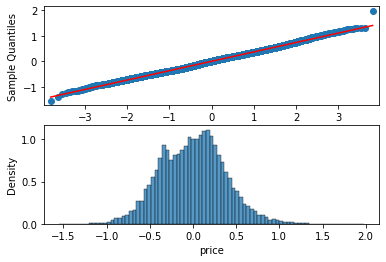

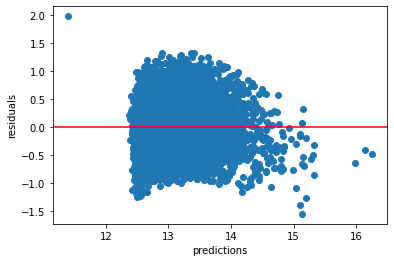

In [36]:
plot_qq_norm(simple_yhat_train, simple_residuals_train, simple_yhat_test, simple_residuals_test)
plot_skedacity(simple_yhat_train, simple_residuals_train, simple_yhat_test, simple_residuals_test)


We haven't violated our Linear Regression model assumptions. Yay!

### Model 1 : Attempt to improve model predictions by including features that describe house condition

Key features that describe house condition include `house_age`, whether it was recently `renovated`, and overall building `grade` of the house. Description of grade categories is provided at the [King County Assessor](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r). 

We removed `condition` categories because they did not correlate with house `price` (when coded as an ordinal variable.)

We'll call this Model 1

In [38]:
# drop 'grade_7average' from OHE grade cols
model_1_cols = simple_model_cols + \
    ['renovated', 'house_age'] + ohe_grade_cols

X1_train = X_train[model_1_cols]
X1_test = X_test[model_1_cols]

m1_yhat_train,m1_residuals_train, m1_yhat_test, m1_residuals_test = build_model(X1_train, X1_test, y_train, y_test)

Train R2: 0.6415772007933189
Test R2: 0.630846255390473
Train RMSE: 213537.07281110913
Test RMSE: 258567.10304245935


Our R2 and RMSE is improving and already better than our dummy model. Yay! Let's check for our assumptions again. 

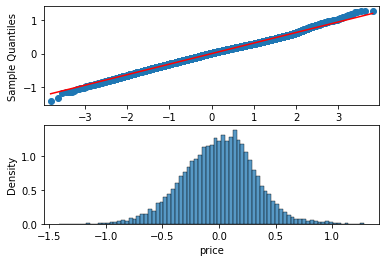

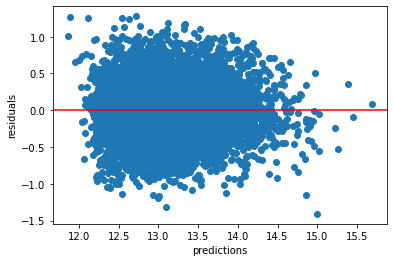

In [39]:
plot_qq_norm(m1_yhat_train,m1_residuals_train, m1_yhat_test,m1_residuals_test)
plot_skedacity(m1_yhat_train,m1_residuals_train, m1_yhat_test,m1_residuals_test)

### Model 2: Attempt to further improve model predictions with premium location features

Key features in this category describe whether the house is on `waterfront` property, and whether the house has a scenic `view` of landmarks in the area.

We'll call this Model 2.

In [40]:
model_2_cols = model_1_cols + \
    ['waterfront_yes'] + ohe_view_cols

X2_train = X_train[model_2_cols]
X2_test = X_test[model_2_cols]

m2_yhat_train,m2_residuals_train, m2_yhat_test, m2_residuals_test = build_model(X2_train, X2_test, y_train, y_test)

Train R2: 0.6528675826515022
Test R2: 0.6424297359772333
Train RMSE: 203962.52131985629
Test RMSE: 250554.67584106108


Check for assumptions.

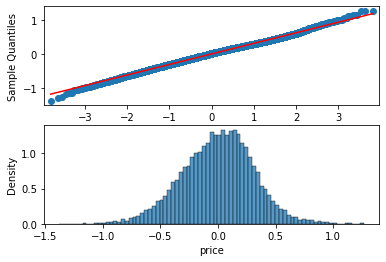

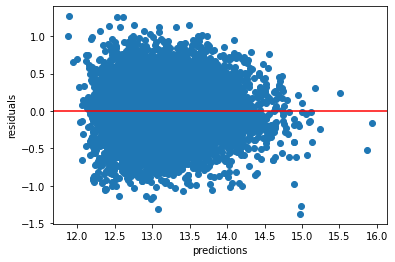

In [41]:
plot_qq_norm(m2_yhat_train,m2_residuals_train, m2_yhat_test,m2_residuals_test)
plot_skedacity(m2_yhat_train,m2_residuals_train, m2_yhat_test,m2_residuals_test)

### Model 3: Improve predictions by capturing neighborhoods or distance relative to center of Seattle

Key features include `dist_seattle`, which is the number of miles away from the geographic centroid of Seattle city limits, and the `neighborhood` if the house is located within Seattle.

In [42]:
model_3_cols = model_2_cols + \
    ['dist_seattle'] + ohe_neigh_cols

X3_train = X_train[model_3_cols]
X3_test = X_test[model_3_cols]

m3_yhat_train,m3_residuals_train, m3_yhat_test, m3_residuals_test= build_model(X3_train, X3_test, y_train, y_test)

Train R2: 0.766748661389074
Test R2: 0.7562951260928505
Train RMSE: 183213.33485501073
Test RMSE: 298454.0958228795


The additional featuresin our model have improved our model so much compared to the dummy, simple and 2 models after. 

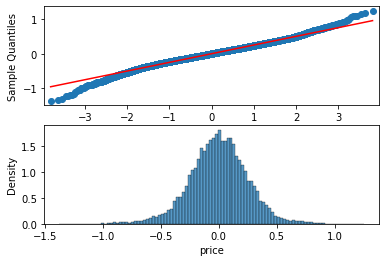

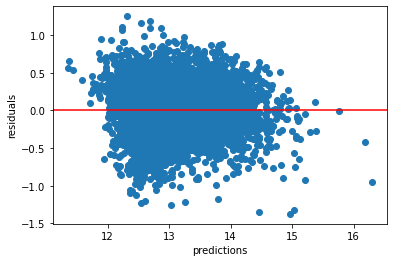

In [43]:
plot_qq_norm(m3_yhat_train,m3_residuals_train, m3_yhat_test,m3_residuals_test)
plot_skedacity(m3_yhat_train,m3_residuals_train, m3_yhat_test,m3_residuals_test)

And we're still great on assumptions!

### Model 4: Attempt to improve model predictions with information about the `zipcode` of the house

The `zipcode` of each house is used as a set of categorical predictors.

In [44]:
model_4_cols = model_3_cols + ohe_zip_cols

X4_train = X_train[model_4_cols]
X4_test = X_test[model_4_cols]

m4_yhat_train,m4_residuals_train, m4_yhat_test, m4_residuals_test = build_model(X4_train, X4_test, y_train, y_test)
# Used the function build_model() on model_4_cols
# saved variables for accessability

Train R2: 0.876641953026694
Test R2: 0.8747088117471509
Train RMSE: 157683.73132459912
Test RMSE: 220798.88026453074


## Get human readable coefficients using statsmodels ols model summary

Many of the inferential statistics about the models are easier to access from a standard OLS regression table. We produced ols model summaries (using `statsmodels.formula.api.ols`) and assessed multicollinearity of features in the model (using `statsmodels.stats.outliers_influence.variance_inflation_factor`, aka VIF)


We ran these models predicting the untransformed target variable `price`, so that coefficients would be interpretable in \$ values.

### Create functions to run model summary and check VIF.

In [45]:
def build_ols_model(cols_list,training_df):
    
    """
    This function takes in columns list from which to build formula from and the training dataframe to build model from.
    The function then returns the model summary of an ordinary linear regression model and the formula used.
    """
    
    model_formula = 'price ~ ' + ' + '.join(cols_list)
    print(model_formula)

    model = ols(model_formula, train_df).fit()
    model_summary = model.summary()
    return model_summary, model_formula

In [46]:
# Code borrowed from lecture slides and put into function
def make_vif(formula, df):

    y, X = dmatrices(formula, data=df, return_type='dataframe')

    # make empty VIF dataframe
    vif = pd.DataFrame()
    vif["feature"] = X.columns
  
    # calculate VIF for each feature
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

    return vif

Concatenate X_train and y_train back together into a DataFrame to make working with ols easier.

In [47]:
y_train = np.exp(y_train)

In [48]:
train_df = pd.concat([X_train,y_train], axis=1)

### Baseline model: Check coefficients and multicollinearity of simple model

Simple model includes `sqft_living` and `bedrooms` features

In [49]:
simple_mod_summary, simple_mod_formula = build_ols_model(simple_model_cols,train_df)
simple_mod_summary

price ~ sqft_living + bedrooms + sqft_lot + floors + has_basement


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     3025.
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:47:48   Log-Likelihood:            -2.0068e+05
No. Observations:               14469   AIC:                         4.014e+05
Df Residuals:                   14463   BIC:                         4.014e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     5.968e+04   9566.982      6.239      0.000    4.09e+04    7.84e+04
sqft_living    308.3734      3.147     97.977      0.000     302.204     314.543
bedrooms     -5.753e+04   2792.892    -20.597      0.000    -6.3e+04   -5.21e+04
sqft_lot        -0.2711      0.051     -5.293      0.000      -0.371      -0.171
floors        1.614e+04   4504.657      3.582      0.000    7306.608     2.5e+04
has_basement  3.759e+04   4789.778      7.849      0.000    2.82e+04     4.7e+04
==============================================================================
Omnibus:                     9585.139   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           312457.419
Skew:                           2.713   Prob(JB):                         0.00
Kurtosis:                      25.109   Cond. No.                     2.16e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.16e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
display(make_vif(simple_mod_formula, train_df))

,feature,VIF
0,Intercept,20.291716
1,sqft_living,1.847287
2,bedrooms,1.507749
3,sqft_lot,1.053890
4,floors,1.319007
5,has_basement,1.212025


### Model 1: Check coefficients and multicollinearity of model adding house condition features

Adds `renovated`, `house_age`, and building `grade` features

In [51]:
model_1_summary, model_1_formula = build_ols_model(model_1_cols,train_df)
model_1_summary

price ~ sqft_living + bedrooms + sqft_lot + floors + has_basement + renovated + house_age + grade_10verygood + grade_11excellent + grade_12luxury + grade_13mansion + grade_3poor + grade_4low + grade_5fair + grade_6lowaverage + grade_8good + grade_9better


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     1505.
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:47:52   Log-Likelihood:            -1.9849e+05
No. Observations:               14469   AIC:                         3.970e+05
Df Residuals:                   14451   BIC:                         3.971e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -5.548e+04   1.07e+04     -5.184      0.000   -7.65e+04   -3.45e+04
sqft_living         168.7119      3.907     43.187      0.000     161.055     176.369
bedrooms          -2.689e+04   2492.657    -10.786      0.000   -3.18e+04    -2.2e+04
sqft_lot             -0.1971      0.044     -4.471      0.000      -0.284      -0.111
floors             5.498e+04   4290.870     12.813      0.000    4.66e+04    6.34e+04
has_basement       4.666e+04   4246.458     10.988      0.000    3.83e+04     5.5e+04
renovated          3.859e+04   2.08e+04      1.859      0.063   -2103.649    7.93e+04
house_age          3412.5698     76.633     44.532      0.000    3262.360    3562.780
grade_10verygood   4.435e+05   1.07e+04     41.604      0.000    4.23e+05    4.64e+05
grade_11excellent  7.212e+05   1.68e+04     42.947      0.000    6.88e+05    7.54e+05
grade_12luxury     1.222e+06   3.07e+04     39.764      0.000    1.16e+06    1.28e+06
grade_13mansion    2.203e+06   9.18e+04     23.999      0.000    2.02e+06    2.38e+06
grade_3poor         -1.2e+05    2.2e+05     -0.546      0.585   -5.51e+05    3.11e+05
grade_4low        -1.244e+05   4.94e+04     -2.517      0.012   -2.21e+05   -2.75e+04
grade_5fair       -1.297e+05   1.83e+04     -7.097      0.000   -1.66e+05   -9.39e+04
grade_6lowaverage -8.741e+04   6989.184    -12.506      0.000   -1.01e+05   -7.37e+04
grade_8good        9.891e+04   5017.086     19.715      0.000    8.91e+04    1.09e+05
grade_9better      2.482e+05   7496.449     33.108      0.000    2.34e+05    2.63e+05
==============================================================================
Omnibus:                    10047.686   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           496009.579
Skew:                           2.767   Prob(JB):                         0.00
Kurtosis:                      31.144   Cond. No.                     5.44e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.44e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [52]:
display(make_vif(model_1_formula, train_df))

,feature,VIF
0,Intercept,34.342912
1,sqft_living,3.849686
2,bedrooms,1.624676
3,sqft_lot,1.056685
4,floors,1.618957
5,has_basement,1.288711
6,renovated,1.010497
7,house_age,1.531593
8,grade_10verygood,1.744503
9,grade_11excellent,1.548827


### Model 2: Check coefficients and multicollinearity of model adding premium location features

Adds `waterfront` and scenic `view` features

In [53]:
model_2_summary, model_2_formula = build_ols_model(model_2_cols,train_df)
model_2_summary

price ~ sqft_living + bedrooms + sqft_lot + floors + has_basement + renovated + house_age + grade_10verygood + grade_11excellent + grade_12luxury + grade_13mansion + grade_3poor + grade_4low + grade_5fair + grade_6lowaverage + grade_8good + grade_9better + waterfront_yes + view_average + view_excellent + view_fair + view_good + view_missing


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     1308.
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:47:55   Log-Likelihood:            -1.9771e+05
No. Observations:               14469   AIC:                         3.955e+05
Df Residuals:                   14445   BIC:                         3.957e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -3.593e+04   1.02e+04     -3.533      0.000   -5.59e+04    -1.6e+04
sqft_living         151.8692      3.736     40.652      0.000     144.547     159.192
bedrooms          -1.862e+04   2373.665     -7.846      0.000   -2.33e+04    -1.4e+04
sqft_lot             -0.2134      0.042     -5.091      0.000      -0.296      -0.131
floors             5.264e+04   4069.892     12.935      0.000    4.47e+04    6.06e+04
has_basement       3.667e+04   4059.754      9.034      0.000    2.87e+04    4.46e+04
renovated          4.229e+04   1.97e+04      2.148      0.032    3698.595    8.09e+04
house_age          3083.9138     73.528     41.942      0.000    2939.790    3228.038
grade_10verygood   4.202e+05   1.02e+04     41.387      0.000       4e+05     4.4e+05
grade_11excellent  6.852e+05    1.6e+04     42.878      0.000    6.54e+05    7.17e+05
grade_12luxury     1.175e+06   2.92e+04     40.186      0.000    1.12e+06    1.23e+06
grade_13mansion    2.196e+06   8.72e+04     25.178      0.000    2.02e+06    2.37e+06
grade_3poor       -1.053e+05   2.08e+05     -0.505      0.613   -5.14e+05    3.03e+05
grade_4low         -1.26e+05   4.69e+04     -2.690      0.007   -2.18e+05   -3.42e+04
grade_5fair       -1.399e+05   1.73e+04     -8.072      0.000   -1.74e+05   -1.06e+05
grade_6lowaverage -8.838e+04   6626.625    -13.338      0.000   -1.01e+05   -7.54e+04
grade_8good        9.359e+04   4773.742     19.606      0.000    8.42e+04    1.03e+05
grade_9better      2.389e+05   7141.866     33.457      0.000    2.25e+05    2.53e+05
waterfront_yes     6.064e+05   2.55e+04     23.818      0.000    5.57e+05    6.56e+05
view_average       5.206e+04   8543.891      6.093      0.000    3.53e+04    6.88e+04
view_excellent     2.383e+05   1.74e+04     13.724      0.000    2.04e+05    2.72e+05
view_fair          1.248e+05   1.44e+04      8.677      0.000    9.66e+04    1.53e+05
view_good          1.109e+05   1.16e+04      9.597      0.000    8.83e+04    1.34e+05
view_missing       3.841e+04   3.11e+04      1.234      0.217   -2.26e+04    9.94e+04
==============================================================================
Omnibus:                     8388.329   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           313968.099
Skew:                           2.178   Prob(JB):                         0.00
Kurtosis:                      25.401   Cond. No.                     5.44e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.44e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
display(make_vif(model_2_formula, train_df))

,feature,VIF
0,Intercept,34.502619
1,sqft_living,3.917287
2,bedrooms,1.639238
3,sqft_lot,1.063208
4,floors,1.620585
5,has_basement,1.310577
6,renovated,1.010975
7,house_age,1.568852
8,grade_10verygood,1.760301
9,grade_11excellent,1.560675


### Model 3: Check coefficients and multicollinearity of model adding neighborhood and distance from Seattle features

Adds `dist_seattle` and `neighborhood` category features

In [55]:
model_3_summary, model_3_formula = build_ols_model(model_3_cols, train_df)
model_3_summary

price ~ sqft_living + bedrooms + sqft_lot + floors + has_basement + renovated + house_age + grade_10verygood + grade_11excellent + grade_12luxury + grade_13mansion + grade_3poor + grade_4low + grade_5fair + grade_6lowaverage + grade_8good + grade_9better + waterfront_yes + view_average + view_excellent + view_fair + view_good + view_missing + dist_seattle + neighborhood_ballard + neighborhood_beaconhill + neighborhood_capitolhill + neighborhood_cascade + neighborhood_centralarea + neighborhood_delridge + neighborhood_downtown + neighborhood_greaterduwamish + neighborhood_interbay + neighborhood_lakecity + neighborhood_magnolia + neighborhood_northcentral + neighborhood_northeast + neighborhood_northgate + neighborhood_northwest + neighborhood_queenanne + neighborhood_rainiervalley + neighborhood_sewardpark + neighborhood_universitydistrict + neighborhood_westseattle


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     976.3
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:47:58   Log-Likelihood:            -1.9587e+05
No. Observations:               14469   AIC:                         3.918e+05
Df Residuals:                   14424   BIC:                         3.922e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        3.144e+05   1.09e+04     28.934      0.000    2.93e+05    3.36e+05
sqft_living                       188.0333      3.394     55.407      0.000     181.381     194.685
bedrooms                        -1.311e+04   2110.344     -6.214      0.000   -1.72e+04   -8976.331
sqft_lot                            0.2815      0.038      7.413      0.000       0.207       0.356
floors                          -2.413e+04   4081.816     -5.911      0.000   -3.21e+04   -1.61e+04
has_basement                      -3.8e+04   3879.763     -9.794      0.000   -4.56e+04   -3.04e+04
renovated                        5.521e+04   1.74e+04      3.176      0.001    2.11e+04    8.93e+04
house_age                         660.2538     78.500      8.411      0.000     506.383     814.125
grade_10verygood                 3.088e+05   9128.040     33.825      0.000    2.91e+05    3.27e+05
grade_11excellent                5.308e+05   1.43e+04     37.101      0.000    5.03e+05    5.59e+05
grade_12luxury                   9.707e+05    2.6e+04     37.377      0.000     9.2e+05    1.02e+06
grade_13mansion                  1.905e+06   7.71e+04     24.714      0.000    1.75e+06    2.06e+06
grade_3poor                      3.255e+05   1.84e+05      1.772      0.076   -3.46e+04    6.86e+05
grade_4low                      -8776.2096   4.14e+04     -0.212      0.832   -8.99e+04    7.23e+04
grade_5fair                     -4.255e+04   1.54e+04     -2.767      0.006   -7.27e+04   -1.24e+04
grade_6lowaverage               -3.671e+04   5973.345     -6.146      0.000   -4.84e+04    -2.5e+04
grade_8good                      5.683e+04   4253.011     13.363      0.000    4.85e+04    6.52e+04
grade_9better                    1.591e+05   6434.307     24.721      0.000    1.46e+05    1.72e+05
waterfront_yes                   6.341e+05   2.25e+04     28.217      0.000     5.9e+05    6.78e+05
view_average                     5.933e+04   7564.910      7.842      0.000    4.45e+04    7.42e+04
view_excellent                   2.505e+05   1.53e+04     16.321      0.000     2.2e+05    2.81e+05
view_fair                        1.092e+05   1.28e+04      8.557      0.000    8.42e+04    1.34e+05
view_good                        1.213e+05   1.02e+04     11.854      0.000    1.01e+05    1.41e+05
view_missing                     5.593e+04   2.74e+04      2.038      0.042    2145.181     1.1e+05
dist_seattle                    -1.533e+04    329.996    -46.456      0.000    -1.6e+04   -1.47e+04
neighborhood_ballard             4.473e+04   1.08e+04      4.124      0.000    2.35e+04     6.6e+04
neighborhood_beaconhill         -1.311e+05   1.41e+04     -9.298      0.000   -1.59e+05   -1.03e+05
neighborhood_capitolhill         2.313e+05   1.48e+04     15.580      0.000    2.02

In [56]:
display(make_vif(model_3_formula, train_df) )

,feature,VIF
0,Intercept,50.756521
1,sqft_living,4.164756
2,bedrooms,1.669364
3,sqft_lot,1.123854
4,floors,2.100168
5,has_basement,1.542109
6,renovated,1.015546
7,house_age,2.303891
8,grade_10verygood,1.833618
9,grade_11excellent,1.611808


### Model 4: Check coefficients and multicollinearity of model adding King County zipcodes features

Adds `zipcodes` category features

In [57]:
model_4_summary, model_4_formula = build_ols_model(model_4_cols, train_df)
model_4_summary

price ~ sqft_living + bedrooms + sqft_lot + floors + has_basement + renovated + house_age + grade_10verygood + grade_11excellent + grade_12luxury + grade_13mansion + grade_3poor + grade_4low + grade_5fair + grade_6lowaverage + grade_8good + grade_9better + waterfront_yes + view_average + view_excellent + view_fair + view_good + view_missing + dist_seattle + neighborhood_ballard + neighborhood_beaconhill + neighborhood_capitolhill + neighborhood_cascade + neighborhood_centralarea + neighborhood_delridge + neighborhood_downtown + neighborhood_greaterduwamish + neighborhood_interbay + neighborhood_lakecity + neighborhood_magnolia + neighborhood_northcentral + neighborhood_northeast + neighborhood_northgate + neighborhood_northwest + neighborhood_queenanne + neighborhood_rainiervalley + neighborhood_sewardpark + neighborhood_universitydistrict + neighborhood_westseattle + zip_98002 + zip_98003 + zip_98004 + zip_98005 + zip_98006 + zip_98007 + zip_98008 + zip_98010 + zip_98011 + zip_98014 +

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     646.1
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:48:01   Log-Likelihood:            -1.9279e+05
No. Observations:               14469   AIC:                         3.858e+05
Df Residuals:                   14355   BIC:                         3.867e+05
Df Model:                         113                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        1.687e+05   2.42e+04      6.974      0.000    1.21e+05    2.16e+05
sqft_living                       170.6962      2.805     60.844      0.000     165.197     176.195
bedrooms                        -8643.9812   1727.211     -5.005      0.000    -1.2e+04   -5258.424
sqft_lot                            0.2176      0.032      6.806      0.000       0.155       0.280
floors                          -1.748e+04   3381.881     -5.167      0.000   -2.41e+04   -1.08e+04
has_basement                    -3.239e+04   3202.024    -10.115      0.000   -3.87e+04   -2.61e+04
renovated                        6.535e+04   1.41e+04      4.628      0.000    3.77e+04     9.3e+04
house_age                         396.9622     65.511      6.059      0.000     268.552     525.372
grade_10verygood                 2.335e+05   7676.219     30.419      0.000    2.18e+05    2.49e+05
grade_11excellent                4.171e+05   1.18e+04     35.238      0.000    3.94e+05     4.4e+05
grade_12luxury                   8.012e+05   2.14e+04     37.474      0.000    7.59e+05    8.43e+05
grade_13mansion                  1.768e+06   6.29e+04     28.125      0.000    1.65e+06    1.89e+06
grade_3poor                      1.754e+05   1.49e+05      1.175      0.240   -1.17e+05    4.68e+05
grade_4low                       2.255e+04   3.37e+04      0.670      0.503   -4.34e+04    8.85e+04
grade_5fair                     -1.287e+04   1.26e+04     -1.021      0.307   -3.76e+04    1.18e+04
grade_6lowaverage               -1.077e+04   4943.918     -2.178      0.029   -2.05e+04   -1077.946
grade_8good                      2.888e+04   3551.225      8.131      0.000    2.19e+04    3.58e+04
grade_9better                    1.059e+05   5382.121     19.678      0.000    9.54e+04    1.16e+05
waterfront_yes                   6.457e+05   1.85e+04     34.824      0.000    6.09e+05    6.82e+05
view_average                      7.06e+04   6232.878     11.327      0.000    5.84e+04    8.28e+04
view_excellent                   2.882e+05   1.26e+04     22.872      0.000    2.64e+05    3.13e+05
view_fair                         7.56e+04   1.04e+04      7.241      0.000    5.51e+04    9.61e+04
view_good                        1.466e+05   8417.558     17.416      0.000     1.3e+05    1.63e+05
view_missing                     5.843e+04   2.23e+04      2.622      0.009    1.47e+04    1.02e+05
dist_seattle                    -8709.7813    953.394     -9.136      0.000   -1.06e+04   -6841.007
neighborhood_ballard              6.63e+04   2.01e+04      3.297      0.001    2.69e+04    1.06e+05
neighborhood_beaconhill         -5.006e+04   2.77e+04     -1.807      0.071   -1.04e+05    4240.306
neighborhood_capitolhill         8052.6629   3.64e+04      0.221      0.825   -6.33

In [58]:
display(make_vif(model_4_formula, train_df) )

,feature,VIF
0,Intercept,382.918679
1,sqft_living,4.333656
2,bedrooms,1.702675
3,sqft_lot,1.212872
4,floors,2.195130
...,...,...
109,zip_98177,3.012036
110,zip_98178,3.169854
111,zip_98188,1.635342
112,zip_98198,2.007110


Unfortunately, there is substantial collinearity between many zip codes and the neighborhood and dist_seattle information that was in the previous version of the model.

For this reason, we will need to remove those collinear zip codes before the zip code information can be utilized.

And ultimately, Model 3 is officially our best model.

## Data Visualization

### Compare predictions from Simple Model to predictions from Best Model (Model 3)

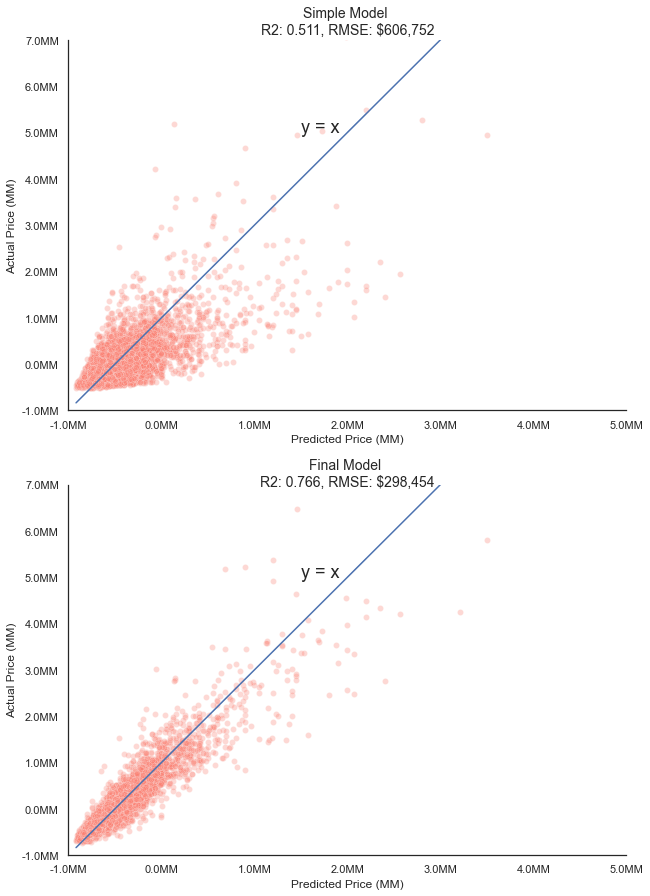

In [67]:
#Plot average prediction error
fig, ax = plt.subplots (2,1,figsize = (10,15))

sns.set_theme(style = 'white')

ax1 = sns.scatterplot(x=np.exp(y_test), y=np.exp(simple_yhat_test), ax = ax[0], color = 'salmon', alpha = 0.3)
sns.lineplot(x=np.exp(y_test), y=np.exp(y_test), ax = ax[0])

ax2 = sns.scatterplot(x=np.exp(y_test), y=np.exp(m4_yhat_test), ax = ax[1], color = 'salmon', alpha = 0.3)
sns.lineplot(x=np.exp(y_test), y=np.exp(y_test), ax = ax[1])

x_label = 'Predicted Price (MM)'
y_label = 'Actual Price (MM)'
tick_labels = ['{:,.1f}'.format(x) + 'MM' for x in ax1.get_xticks()/1000000]
ax1.set_xticklabels(tick_labels)
ax2.set_xticklabels(tick_labels)
ax1.set_yticklabels(tick_labels)
ax2.set_yticklabels(tick_labels)

ax1.set_xlabel(x_label)
ax2.set_xlabel(x_label)
ax1.set_ylabel(y_label)
ax2.set_ylabel(y_label)

ax1.set_xlim([0, 6000000])
ax1.set_ylim([0, 4000000])

ax2.set_xlim([0, 6000000])
ax2.set_ylim([0, 4000000])

ax1.set_title('Simple Model \nR2: 0.511, RMSE: $606,752',fontsize = 14)
ax2.set_title('Final Model \nR2: 0.766, RMSE: $298,454', fontsize = 14, loc = 'center',y=0.98)

ax1.annotate('y = x', xy =(2500000,3000000), fontsize = 18)
ax2.annotate('y = x', xy =(2500000,3000000), fontsize = 18)


sns.despine()

plt.savefig('Images/model_performance.jpg',bbox_inches="tight",dpi=300)

This demonstrates that our final model has greatly improved our ability to predict house prices in the King County area, given specific information about the house, neighborhoods, and amenities. With this model, millenials will have more information to inform house buying decisions, thereby saving money and getting homes that meet their needs.

### Plot price of houses in Seattle versus houses outside of the city

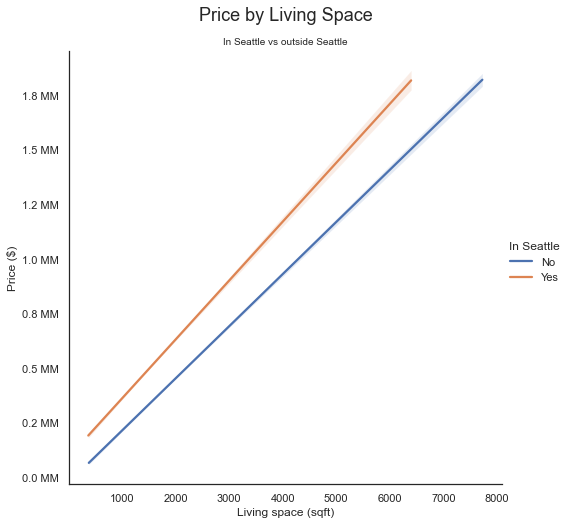

In [70]:
import matplotlib.ticker as tkr
# # fig, ax = plt.subplots(ncols = 2,)
# f, ax = plt.subplots(1, 2)

g = sns.lmplot(x='sqft_living', y='price', hue = 'in_seattle',data=housing_df[housing_df['price']<2000000], scatter = False,facet_kws={'legend_out': True},height = 7)
# ax1.set_xlabel ('Living space (sqft)')
# ax1.set_ylabel('Price')


# plt.figure(figsize = (15,20))
plt.xlabel("Living space (sqft)")
plt.ylabel("Price ($)")
plt.title('In Seattle vs outside Seattle', y=1, fontsize=10)
plt.suptitle('Price by Living Space',y=1.04,fontsize = 18)
# title
new_title = 'In Seattle'
g._legend.set_title(new_title)
# replace labels
new_labels = ['No', 'Yes']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
# plt.ticklabel_format(style='plain', axis='y');
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{(y/1000000):.1f} MM'))

plt.savefig('Images/price_by_living_space.jpg',bbox_inches="tight",dpi=300)

plt.show(g)

### Display median home prices by neighborhood within Seattle

The figure for median house price by neighborhood in Seattle is plotted in the notebook ***add_city_neighborhood.ipynb*** , available in our repo. For any interest in geospatial processing done in this project, please refer to that notebook.

<img src='Images/mean_price_by_neighborhood_map.jpg' alt="Figure of Median house price by neighborhood in Seattle" title="Median house price by neighborhood in Seattle" />

### House prices displayed on map of King County

The map of house prices within King County was created within the notebook ***add_city_neighborhood.ipynb*** , available in our repo. For any interest in geospatial processing done in this project, please refer to that notebook.

This map show that house prices are higher around waterfront areas, within certain neighborhoods, and within proximity to Seattle city and certain zip codes.


<img src='Images/property_price_map.jpg' alt="Figure of property price across King county, Washington" title="Property price across King county, Washington" />

### Display mean house prices by number of bedrooms and living space

House prices increase as square foot of living space increases. However, for houses with similar amounts of living space, those with more bedrooms will cost ***less*** on average. This is likely because each room will be smaller. But this could be useful information for new or growing families to consider.

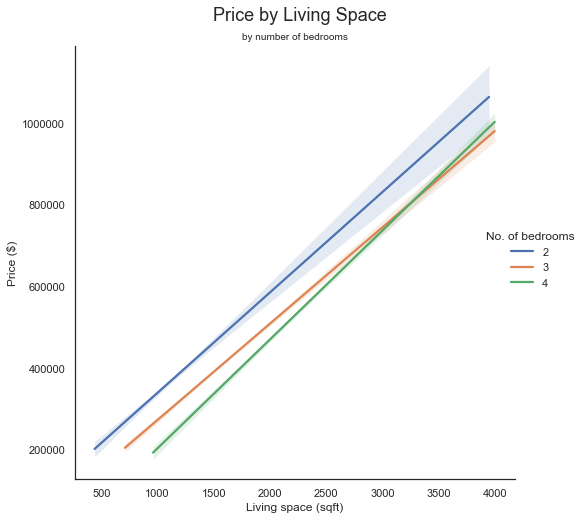

In [69]:
filt = (train_df['bedrooms'].isin([2,3,4])) & (train_df['price'] <= 2000000) & (train_df['sqft_living'] <=4000)
cleaner_train_df = train_df[filt]
cleaner_train_df['price'] = cleaner_train_df['price']

g=sns.lmplot(y='price', x='sqft_living', hue='bedrooms', data=cleaner_train_df, scatter=False, facet_kws={'legend_out': True}, height = 7)
plt.xlabel("Living space (sqft)")
plt.ylabel("Price ($)")
plt.title('by number of bedrooms', y=1, fontsize=10)
plt.suptitle('Price by Living Space',y=1.03,fontsize = 18)
# title
new_title = 'No. of bedrooms'
g._legend.set_title(new_title)
# replace labels
new_labels = ['2','3','4']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
plt.ticklabel_format(style='plain', axis='y');

plt.savefig('Images/lmplot_price-vs-sqft_living-by_bedrooms.jpg', transparent = False, bbox_inches="tight");

### Display mean housing price by construction grade

Housing costs substantially more for higher quality construction. Also, previously renovated properties cost more, even for houses in the same grade.

Our recommendation is to consider doing work yourself to avoid overpaying for higher grade properties.

In [71]:
# Ordering levels of grade for purpose of plotting
cleaner_train_df['grade_ordinal'] = (cleaner_train_df['grade_3poor']       * 3) + \
                                    (cleaner_train_df['grade_4low']        * 4) + \
                                    (cleaner_train_df['grade_5fair']       * 5) + \
                                    (cleaner_train_df['grade_6lowaverage'] * 6) + \
                                    (cleaner_train_df['grade_7average']    * 7) + \
                                    (cleaner_train_df['grade_8good']       * 8) + \
                                    (cleaner_train_df['grade_9better']     * 9) + \
                                    (cleaner_train_df['grade_10verygood']  * 10) + \
                                    (cleaner_train_df['grade_11excellent'] * 11) + \
                                    (cleaner_train_df['grade_12luxury']    * 12) + \
                                    (cleaner_train_df['grade_13mansion']   * 13)

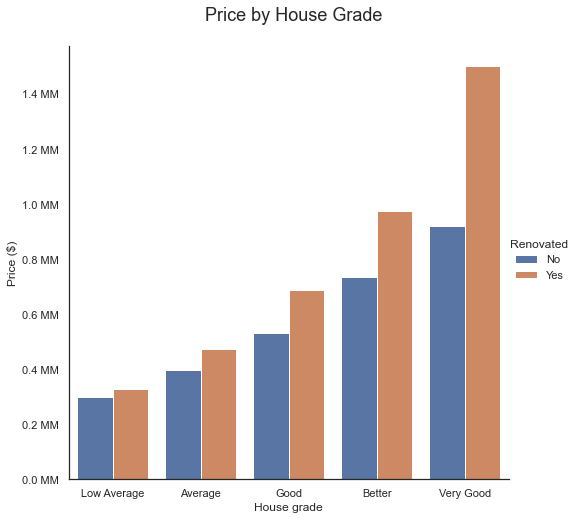

In [72]:
filt = (cleaner_train_df['grade_ordinal'] >= 6) & (cleaner_train_df['grade_ordinal'] <= 10)

import matplotlib.ticker as tkr

ax1 = sns.catplot(x="grade_ordinal", y="price", hue="renovated", kind="bar", data=cleaner_train_df[filt], ci=None, height = 7, legend_out=True)

plt.xlabel("House grade")
plt.ylabel("Price ($)")
# plt.title('by number of bedrooms', y=1, fontsize=10)
plt.suptitle('Price by House Grade',y=1.03,fontsize = 18)

new_title = 'Renovated'
ax1._legend.set_title(new_title)
# replace labels
new_labels = ['No', 'Yes']
for t, l in zip(ax1._legend.texts, new_labels):
    t.set_text(l)

for ax in ax1.axes.flat:
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{(y/1000000):.1f} MM'))
# plt.ticklabel_format(style='plain', axis='y');
values = ['Low Average', 'Average', 'Good', 'Better','Very Good']
default_x_ticks = range(len(values))
plt.xticks(default_x_ticks, values);

plt.savefig('Images/barplot_price-vs-grade-by-renovated.jpg', transparent = False, bbox_inches="tight");

## Conclusions

Our final model, Model 3, includes features regarding house living space, house condition, waterfront property and scenic views, distance from Seattle city center, and neighborhoods within Seattle.


With this model, millenial homebuyers could specify desired features and find what the expected house prices would be. It would also be possible to specify a house range and receive recommendations for neighborhoods and house features that would fit within that budget.

